In [19]:
%pylab inline

%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../src/')
save_path="../"

Populating the interactive namespace from numpy and matplotlib


# Classifying ER vs BA or SBM

In [2]:
import GraphConvNet as gcn
import pickle as pk
import os

/Users/roseyu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


In [3]:
from keras.utils import to_categorical

# Modular GCN

In [4]:
import networkx as nx

def make_BA_dataset(N,n,m=2):
    adj = np.empty((N,n,n), dtype=np.float32)
    for j in range(N):
        g = nx.barabasi_albert_graph(n=n,m=m)
        a = zeros((n,n), dtype=np.float32)
        for i in g.edges:
            a[i] = 1
            a[i[::-1]] = 1
        adj[j] = a
    return adj

def make_ER_dataset(N,n,p=0.1):
    adj = np.empty((N,n,n), dtype=np.float32)
    for j in range(N):
        g = nx.erdos_renyi_graph(n=n, p=p)
        a = zeros((n,n), dtype=np.float32)
        for i in g.edges:
            a[i] = 1
            a[i[::-1]] = 1
        adj[j] = a
    return adj
    
        
def mat_pow_batch(A,n):
    """batch matrix power"""
    if n ==0:
        return np.float32([np.eye(A.shape[1])])
    M = A
    for _ in range(n-1):
        M = tf.matmul(A, M)
    return M.eval()
            

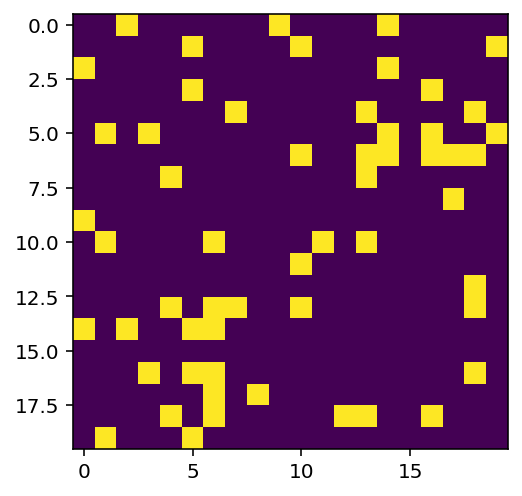

In [5]:
# X = make_BA_dataset(1000, 20)
X = make_ER_dataset(10, 20, p = .2)
imshow(X[0])

# Make large, mixed dataset
make a dataset of BA and ER mixed, with different densities

In [6]:
class Graph_dataset():
    def __init__(self,n_nodes = 20, num_samples = int(2e3), num_graph_densities = 1, max_moment_order = 3,
                 min_BA_density = 1, min_ER_density = 'auto' , max_BA_density = 0.5, max_ER_density = 0.5 ):
        
        self.label_classes = ['BA', 'ER']
        if min_ER_density == 'auto':
            min_ER_density = 1./n_nodes
        
        self._num_in_group = num_samples//(2*num_graph_densities)
        
        self.graph_params = {'BA' : int0(linspace(1, n_nodes* max_BA_density, num_graph_densities)),
                  'ER' : linspace(min_ER_density, max_ER_density, num_graph_densities)}

        self.Adj = {'BA' : concatenate([make_BA_dataset(self._num_in_group, n_nodes, m) for m in self.graph_params['BA']], axis = 0),
                   'ER' : concatenate([make_ER_dataset(self._num_in_group, n_nodes, p) for p in self.graph_params['ER']], axis = 0)}

        self.Adj_all = concatenate((self.Adj['BA'], self.Adj['ER']), axis = 0)
        self.get_label_parameter()
        self.get_graph_moments(n=max_moment_order)
        self.h = np.ones_like(self.moments[1])

    def get_label_parameter(self):
        self.full_labels = []
        for i,k in enumerate(self.label_classes):
            for p in self.graph_params[k]:
                self.full_labels += [[i,p]]*self._num_in_group

    def get_rand_indices(self,):
        self.rand_indices = np.argsort(np.random.rand(len(self.Adj_all)))

    def get_graph_moments(self, n= 3):
        self.moments = {1:self.Adj_all.sum(-1, keepdims=1)}
        for i in range(2,n+1):
            A = gcn.mat_pow_batch(self.Adj_all,i)
            self.moments[i] = A.sum(-1, keepdims=1) 
    
def shuffle_node_order(X):
    Adj_nodes_shuffled = np.empty_like(X)
    for i,a in enumerate(X):
        # get random order
        r = argsort(rand(len(a)))
        Adj_nodes_shuffled[i] = a[r][:,r]
    return Adj_nodes_shuffled

## Configuration model by shuffling outgoing stubs
If we just take the outgoing stubs (-1 in incidence), we are not changing the number of outgoing stubs, but reassigning them to other links. 
Can this ever cause more links? 

In [7]:
def get_incidence(a):
    """make incidence matrix from adjacency matrix"""
    ix = np.where(np.triu(a))
    edg = array(list(zip(*ix)))
    incid = np.zeros((len(a), len(edg)), dtype=np.float32)
    for _,[i,j] in enumerate(edg): 
        incid[i,_] = 1
        incid[j,_] = -1
    return incid

def incidence_shuffle(incid):
    neg = np.where(incid < 0)
    # preserve the rows, to preserve node degree, but shuffle columns, to shuffle links
    np.random.shuffle(neg[1])
    incid2 = 1.* (incid> 0 )
    incid2[neg] -= 1
    return incid2

def configuration_model_1(a, weighted = True):
    incid = get_incidence(a)
    incid2 = incidence_shuffle(incid)
    lap = incid2.dot(incid2.T)
    deg = lap.diagonal() 
    a2 = np.diag(deg)-lap
    if not weighted:
        a2 = (1*(a2>0))
    return a2

# def make_data_config_model(X, weighted = True, shuffle_networks = False, shuffle_nodes = False):
#     print(('Not s' if not shuffle else 'S')+'huffling order')
#     dat = np.array([configuration_model_1(a, weighted) for a in X])
#     dat = np.concatenate((X,dat))
#     print('labels: {0:"real", 1:"fake"}')
#     labels = np.zeros((2*len(X,)), dtype = np.float32)
#     labels[len(X):] = 1
#     if shuffle_networks:
#         idx = np.argsort(np.random.rand(2*len(X)))
#         dat = dat[idx]
#         labels = labels[idx]
#     if shuffle_nodes:
#         dat = shuffle_node_order(dat)
#     return dat, labels
    
def trim_mat(a,b):
    """remove random links from 'a' until it has the same number of links as 'b'"""
    i = (a.sum(0)!= b.sum(0))
    ms = i[:,np.newaxis]*i[np.newaxis]
    masked_a = a*np.triu(ms)
    ix = np.where(masked_a)
    # num missing links
    d = int(a.sum()-b.sum())//2
    # randomly choose r indices to knockout
    r = np.argsort(np.random.rand(len(ix[0])))[:d]
    # make trimmed graph
    c = triu(a) + 0.
    for i in r:
        c[ix[0][i],ix[1][i]]=0
    c += c.T 
    return c
    
def make_data_config_model(X, weighted = True, shuffle_networks = False, shuffle_nodes = False, trim_links = False):
    """ Create a Configuration Model ensemble from adjacency matrices in X (samples, N,N)
    returns concatenate([X,config model of X]) , labels ([0 for X and 1 for Config model])
    weighted: whether links in configuration model are allowed to be weighted 
        (leads to less discrepancy with X in total link weight)
    shuffle_networks: whether output order should be shuffled (default False)
        if False, the first half of the output are the original 
    shuffle_nodes: whether to shuffle node order (default False)
    trim_links: whether to randomly remove links in X so that is has 
        the same number of links the Config. Model X. 
    """
    print(('Not s' if not shuffle else 'S')+'huffling order')
    config = np.array([configuration_model_1(a, weighted) for a in X])
    if trim_links:
        print('trimming links')
        trimmed_X = np.array([trim_mat(a,b) for a,b in zip(X,config)])
        dat = np.concatenate((trimmed_X, config))
    else:
        dat = np.concatenate((X,config))
    print('labels: {0:"real", 1:"fake"}')
    labels = np.zeros((2*len(X,)), dtype = np.float32)
    labels[len(X):] = 1
    if shuffle_networks:
        idx = np.argsort(np.random.rand(2*len(X)))
        dat = dat[idx]
        labels = labels[idx]
    if shuffle_nodes:
        dat = shuffle_node_order(dat)
    return dat, labels

In [8]:
n_list =  [10 ,15, 20, 30, 40,50, 60]
n = n_list[-3] 
data = Graph_dataset(n_nodes=n, num_samples= int(5e3), num_graph_densities=5)
data.get_rand_indices()

data.Adj_all.shape

(5000, 40, 40)

In [9]:
data.graph_params

{'BA': array([ 1,  5, 10, 15, 20]),
 'ER': array([0.025  , 0.14375, 0.2625 , 0.38125, 0.5    ])}

# BA vs ER

In [10]:
data.label_classes

['BA', 'ER']

In [11]:
GRAPH_TYPE = 'BA_vs_ER'
EXP_DIR = '../experiments/gcn_classification_grid_2_no_flatten/'
os.makedirs(EXP_DIR, exist_ok=True)

RUN_FILE = './run_gcn_classification_v2.py'
TRIMMED = False



labels = to_categorical(array(data.full_labels)[:,0]) # first column is BA,ER, second col is parameter m or p 

dataset = {
    'Adj':data.Adj_all, 
    'labels':labels,
    'rand_indices':data.rand_indices 
}

dataset_path = EXP_DIR+'%s-N%d_config_dataset-%d'\
        %(GRAPH_TYPE,data.Adj_all.shape[1] ,len(data.Adj_all)) + ('-trimmed' if TRIMMED else'')+'.pkl'
print(dataset_path)
pk.dump(dataset,open(dataset_path,'wb'))


# SAVE_PATH = '../experiments/gcn_classification_grid/%s/' % GRAPH_TYPE
SAVE_PATH = EXP_DIR+'%s_leaky_relu' % GRAPH_TYPE + ('-trimmed' if TRIMMED else'')+ '/'
os.makedirs(SAVE_PATH, exist_ok=True)


../experiments/gcn_classification_grid_2_no_flatten/BA_vs_ER-N40_config_dataset-5000.pkl


In [12]:
data.Adj['BA'][-1].sum(), data.Adj['ER'][-1].sum()

(800.0, 766.0)

# Config Model Classification

Shuffling order
trimming links
labels: {0:"real", 1:"fake"}
../experiments/gcn_classification_grid_2_no_flatten/BA-N40_config_dataset-5000-trimmed.pkl


(0.0, 1.0)

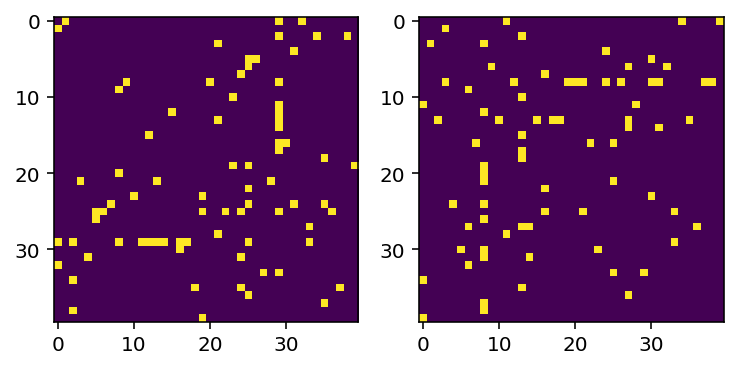

In [13]:

GRAPH_TYPE = 'BA' 
# GRAPH_TYPE = 'ER'

# EXP_DIR = '../experiments/gcn_classification_grid/'
# RUN_FILE = './run_gcn_classification_v1.py'

EXP_DIR = '../experiments/gcn_classification_grid_2_no_flatten/'
RUN_FILE = './run_gcn_classification_v2.py'

os.makedirs(EXP_DIR, exist_ok=True)

TRIMMED = True
# TRIMMED = False
data_config, labels_config = make_data_config_model(data.Adj[GRAPH_TYPE], weighted=False, shuffle_nodes=True, trim_links=TRIMMED)

idx = argsort(rand(len(data_config)))
h = ones(data_config.shape[:2]+(1,))

dataset = {
    'Adj':data_config, 
    'labels':to_categorical(labels_config),
    'rand_indices':idx 
}

dataset_path = EXP_DIR+'%s-N%d_config_dataset-%d'\
        %(GRAPH_TYPE,data.Adj_all.shape[1] ,len(data_config)) + ('-trimmed' if TRIMMED else'')+'.pkl'
print(dataset_path)
pk.dump(dataset,open(dataset_path,'wb'))


# SAVE_PATH = '../experiments/gcn_classification_grid/%s/' % GRAPH_TYPE
SAVE_PATH = EXP_DIR+'%s_leaky_relu' % GRAPH_TYPE + ('-trimmed' if TRIMMED else'')+ '/'
os.makedirs(SAVE_PATH, exist_ok=True)


subplot(121)
imshow(data_config[0])
subplot(122)
imshow(data_config[len(data.Adj[GRAPH_TYPE])])
labels_config[0], labels_config[len(data.Adj[GRAPH_TYPE])]

In [14]:
l = len(data_config)
a = data_config[500]
b = data_config[500+l//2]
a.sum(), b.sum()

(304.0, 304.0)

# Run Experiments

In [15]:
import os 

EPOCHS = 400

ACT = {0: 'linear', 
       1: 'relu', 
       2: 'sigmoid',
       3: 'tanh',
      }

activation = ACT[0]

# units_per_layer = 2
# bias = True
skip = True

params = {
    'units': [], 
    'skip': skip, # whether to pass on skip layers to output
    'activation': activation, # used for all layers
#     'GCN_kws': {'use_bias': bias}, 
#     'dense_kws': {'use_bias': bias}, 
    'final_kws': {'units':10,}, #'activation': 'relu'}, 
    # linear activation is best for final layer
         }

print(RUN_FILE)
for n_layer in range(1,6):
    for units_per_layer in range(1,6,2):
        params['units'] = [units_per_layer] * n_layer
        os.system(RUN_FILE+''' %s "%s" %s %d &''' % ( dataset_path, params, SAVE_PATH , EPOCHS))


./run_gcn_classification_v2.py


# Config. Model vs Real 

In [16]:
b= a.shape[0] # number of bins
c = 100
dif_real = {} 
for i in range(0,len(data_config)//2,c):
    for j in range(i,len(data_config)//2,c):
        for order in range(1,6):
            m = matrix_power(data_config[i],order).sum(0)
            md = matrix_power(data_config[j],order).sum(0)
            
            mn,mx = min(m.min(),md.min()), max(m.max(), md.max())
            h, _ = histogram(m, b, range= (mn,mx), normed=True)
            hd, _ = histogram(md, b, range= (mn,mx), normed=True)
            dif_real[order] = dif_real.get(order,[]) + [abs(h.cumsum()-hd.cumsum()).max()]
        

/Users/roseyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # This is added back by InteractiveShellApp.init_path()
/Users/roseyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if sys.path[0] == '':


In [17]:
b= a.shape[0] # number of bins
c = 100
dif_fake = {} 
for i in range(0,len(data_config)//2,c):
    for j in range(i+len(data_config)//2, len(data_config) ,c):
        for order in range(1,6):
            m = matrix_power(data_config[i],order).sum(0)
            md = matrix_power(data_config[j],order).sum(0)
            
            mn,mx = min(m.min(),md.min()), max(m.max(), md.max())
            h, _ = histogram(m, b, range= (mn,mx), normed=True)
            hd, _ = histogram(md, b, range= (mn,mx), normed=True)
            dif_fake[order] = dif_fake.get(order,[]) + [abs(h.cumsum()-hd.cumsum()).max()]
        

/Users/roseyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # This is added back by InteractiveShellApp.init_path()
/Users/roseyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if sys.path[0] == '':


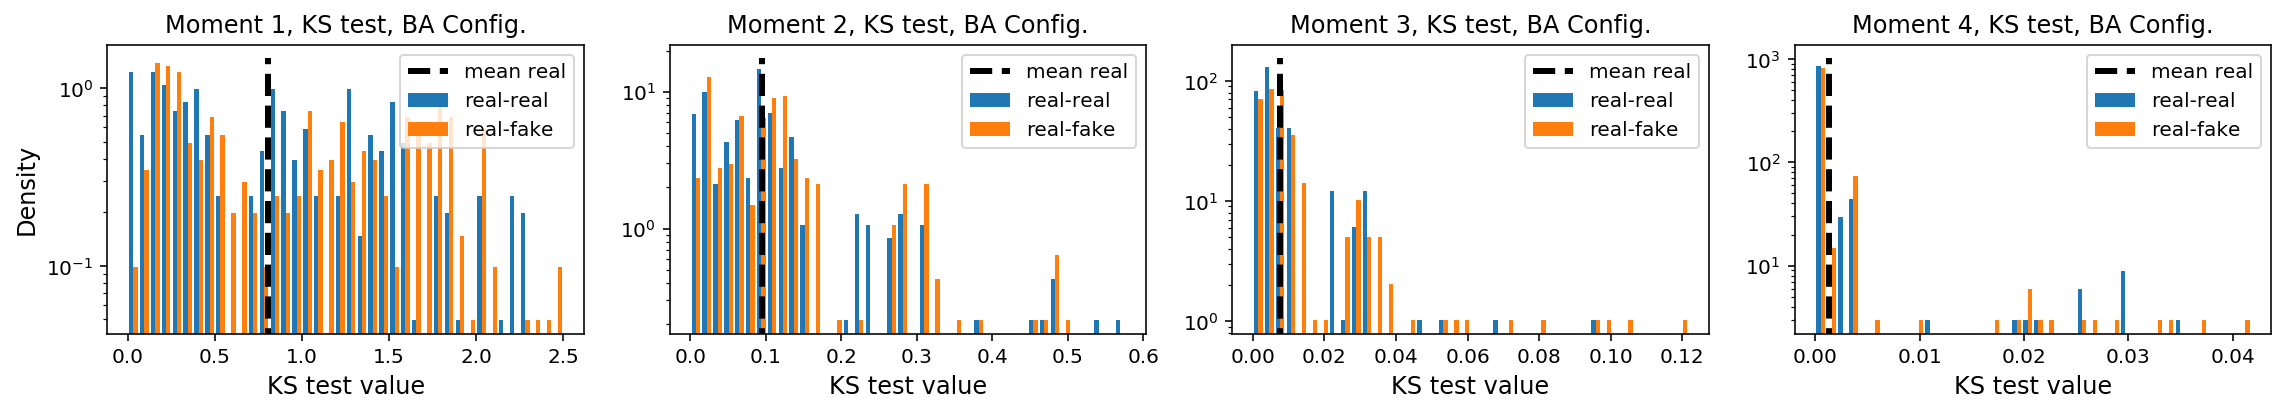

In [20]:
figure(figsize = (16,3))
for k in sorted(dif_real)[:-1]:
    subplot(1,4,k)
    [h,hd],bns,_ = matplotlib.pyplot.hist([dif_real[k],dif_fake[k] ], b, label = ['real-real','real-fake'], log = 1, alpha = 1, density=True)
    title('Moment %d, KS test, BA Config.'%k)
    xlabel('KS test value',fontsize = 12)
    if k == 1:
        ylabel('Density',fontsize = 12)
    plot([mean(dif_real[k])]*2, [min(h), 1.2*max(h)], lw = 3 , c = 'k', ls = '--', label ='mean real')
    legend()
    tight_layout()
    
savefig(save_path+'gcn-config-KS-BA-1-row.pdf')
savefig(save_path+'gcn-config-KS-BA-1-row.png', dpi = 300)

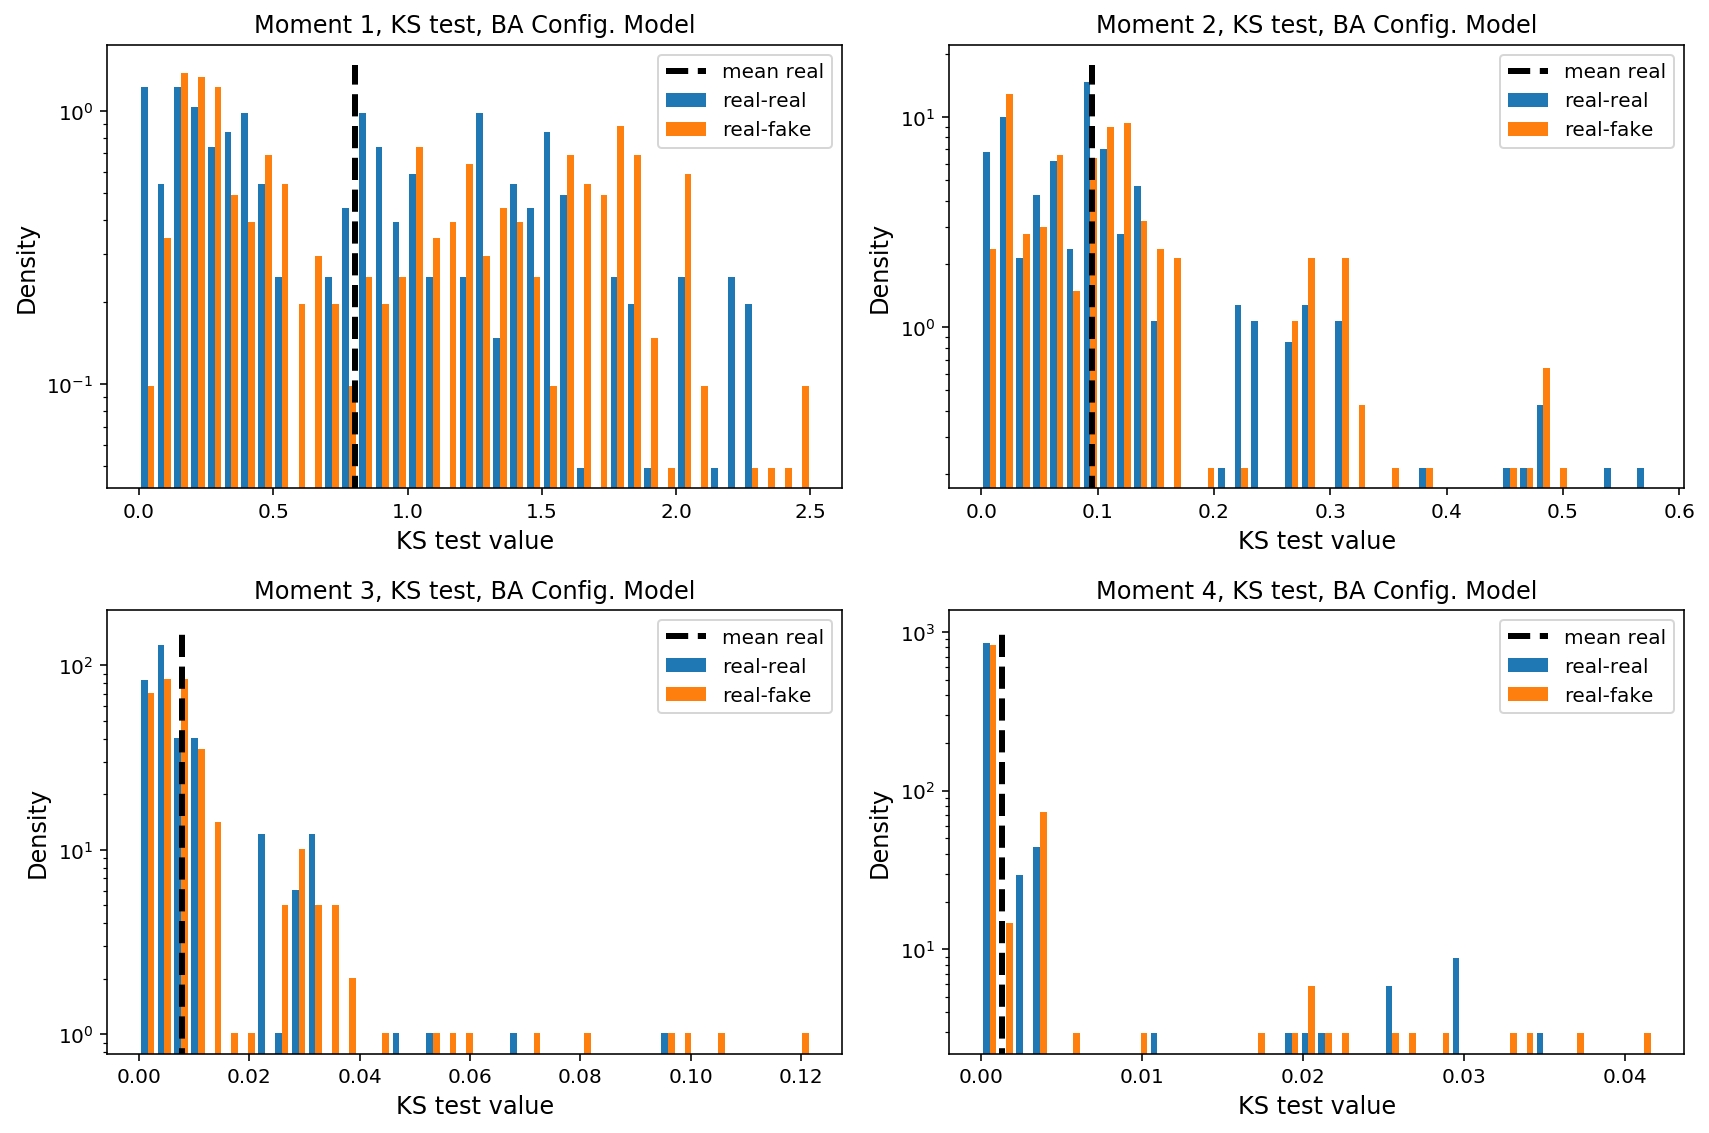

In [21]:
figure(figsize = (12,8))
for k in sorted(dif_real)[:-1]:
    subplot(2,2,k)
    [h,hd],bns,_ = hist([dif_real[k],dif_fake[k] ], b, label = ['real-real','real-fake'], log = 1, alpha = 1, density=True)
    title('Moment %d, KS test, BA Config. Model'%k)
    xlabel('KS test value',fontsize = 12)
    ylabel('Density',fontsize = 12)
    plot([mean(dif_real[k])]*2, [min(h), 1.2*max(h)], lw = 3 , c = 'k', ls = '--', label ='mean real')
    legend()
    tight_layout()
    
savefig(save_path+'gcn-config-KS-BA.pdf')
savefig(save_path+'gcn-config-KS-BA.png', dpi = 300)

In [ ]:
i = 100
a = data_config[i+5]
ad = data_config[i] #+len(data_config)//2]

In [ ]:
a.shape

In [ ]:
from scipy.stats import kstest

In [ ]:
m, md = moments[-1], moments_config[-1]

In [ ]:
b = 20
h = histogram(m, b)
hd = histogram(md, b)

In [ ]:
dif = []
b= 20
for i, (m, md) in enumerate(zip( moments, moments_config)):
    mn,mx = min(m.min(),md.min()), max(m.max(), md.max())
    h, _ = histogram(m, b, range= (mn,mx), normed=True)
    hd, _ = histogram(md, b, range= (mn,mx), normed=True)
#     [h,hd], bns, p = hist([m,md],20, density=1,)# cumulative=1);
#     show()
    #dif+= [[i+1,abs(h-hd).max()]]
    dif+= [[i+1,abs(h.cumsum()-hd.cumsum()).max()]]
#     plt.clf()

In [ ]:
dif = [] 
for i, (m, md) in enumerate(zip( moments, moments_config)):
    [h,hd], bns, p = hist([m,md],20, density=1,)# cumulative=1);
#     show()
    #dif+= [[i+1,abs(h-hd).max()]]
    dif+= [[i+1,abs(h.cumsum()-hd.cumsum()).max()]]
    plt.clf()

In [ ]:
a.shape[0]**(arange(1,6)/2)

In [ ]:
plot(*array(dif).T)
xlabel('moment order')
ylabel('KS difference')

In [ ]:
dif

In [ ]:
hd

In [ ]:
abs(h-hd).max()

In [ ]:
abs(h.cumsum()-hd.cumsum()).max()

In [ ]:
moments = []
moments_config = []
n = a.shape[0]
for i in range(1,6):
    moments += [matrix_power(a,i).sum(0)/ n**(0)]
    moments_config += [matrix_power(ad,i).sum(0)/ n**(0)]
    figure(figsize=(13,4))
    subplot(131, aspect = 1)
    plot(sorted(moments[-1]),sorted(moments_config[-1]), 'o', alpha = 0.5)
    title( 'Moment %d' %i)
    xlabel('BA')
    ylabel('Config BA')
    xscale('log')
    yscale('log')
    
    subplot(132)
    plot(sorted(moments[-1]),label='BA')
    plot(sorted(moments_config[-1]), label='Config BA')
    subplot(133)
    hist([moments[-1], moments_config[-1]],label=['BA','Config BA'])
    legend()
    show()
    

# Config. Model Classification results

In [ ]:
from glob import glob

In [ ]:
pth = SAVE_PATH
# pth = '../experiments/gcn_classification_grid_2_no_flatten/BA_vs_ER_leaky_relu/'
# pth = '../experiments/gcn_classification_grid_2_no_flatten/BA_leaky_relu-trimmed/'
# pth = '../experiments/gcn_classification_grid_2_no_flatten/BA_leaky_relu/'

res = glob(pth + '/gcn*.pkl')
# res = glob( '../experiments/gcn_classification_grid_2_no_flatten/BA_leaky_relu/gcn*.pkl')

len(res)

In [ ]:
# res

In [ ]:
SAVE_PATH

In [ ]:
# n = 50
a = 3
num = round(len(res)/ a)

figure(figsize=(4*a, num*3))
i = 0
for r in sorted(res):
#     if int(r.split('-N')[1].split('-')[0]) != n:
#         continue
    n = int(r.split('-N')[1].split('-')[0])
    subplot(num,a,i+1)
    i+=1
    g = pk.load(open(r, 'rb'))
    n_lay = len(g['params']['units'])
    act = g['params']['activation']
    results.setdefault(act, {})
    u = g['params']['units'][0]
    for k in ['acc', 'val_acc']:
        plot(g['history'][k], label = k)

    legend()
    title('N=%d, %d Lays, %d units, val. acc %.3g' %(n,n_lay, u, max(g['history']['val_acc'])))
#     title(r.split('-N')[1].split('-activation')[0].strip('.pkl')+'\n max val %.3g' % max(g['history']['val_acc']) )
    grid()
    tight_layout()
    
show()

In [ ]:
# mkdir ../figs/expressivity/GCN/configuration_model/

In [ ]:
SAVE_PATH

In [ ]:
typ = pth.strip('/').split('/')[-1]

config_dir = '../figs/expressivity/GCN/configuration_model/' 
# config_dir = '../figs/expressivity/GCN/%s/' %(typ.strip('_leaky_relu'))  
os.makedirs(config_dir, exist_ok=True)
config_dir


In [ ]:
typ

In [ ]:

figs_config = glob('../figs/expressivity/GCN/gcn-config*')
for f in figs_config:
    os.system('mv %s %s'%(f, config_dir))

In [ ]:
typ = pth.strip('/').split('/')[-1]
cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

# stl = ['-','--', ':']
figure(figsize=(10,6))
for ii,n in enumerate(n_list):
    if n==40:continue
    results = {}
    for r in res:
        if int(r.split('-N')[1].split('-')[0]) != n:
            continue
    #     print(r)
        g = pk.load(open(r, 'rb'))
        
        n_lay = len(g['params']['units'])
        act = g['params']['activation']
        results.setdefault(act, {})
        u = g['params']['units'][0]
        results[act][u] = results[act].get(u,[]) +[[n_lay,max(g['history']['val_acc'])]]


    for a in results:
        r1 = results[a]
        results[a] = {k: array(results[a][k])[argsort(array(results[a][k])[:,0])] for k in results[a]}
        
    for a in results:
        r1 = results[a]
        for i1,k in enumerate(sorted(r1)):
            plot(*r1[k][:-1].T, label = 'N=%d, u=%d' %(n,k), #ls= stl[i1],#marker = '.',
                 lw=1.5*k**1.2 , alpha= 1-tanh(k/10), c= cols[ii])
        t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
        title('%s GCN activation, %s' %(a.capitalize(), t) + (', pruned' if '-trimmed' in res[0] else ''), size=16 )
        xlabel('# layers', size = 14)
        ylabel('Test accuracy', size = 14)
        xticks(arange(1,6),fontsize=12)
#         if ylim()[0] >0.95:
#             ylim(0.95,1.01)
#         ylim(0.75,1.01)
#         legend(ncol=5)

legend(fontsize= 12)
grid()

tight_layout()

nam = config_dir+'gcn-1-%s-All'%(typ) + ('-trimmed' if '-trimmed' in res[0] else '')
print(nam)

savefig(nam +'.pdf')
savefig(nam +'.png', dpi=300)
        
#         show()


In [ ]:
columns = {v:k for k,v in enumerate(['n','layers','units','val_acc','activation'])}
full_res = []
for r in res:
    g = pk.load(open(r, 'rb'))
    
    l = [None]*len(columns)
    l[columns['n']] = int(r.split('-N')[1].split('-')[0])
    l[columns['layers']] = len(g['params']['units'])
    l[columns['activation']] = g['params']['activation']
    results.setdefault(act, {})
    l[columns['units']] = g['params']['units'][0]
    l[columns['val_acc']] = max(g['history']['val_acc'])
#     if l[columns['n']]== 20: 
#         print('hi')
#         continue
    full_res += [l]
    
full_res = array(full_res)


s = set(full_res[:, columns['activation']])
results = {a: np.float32(full_res[where(full_res[:, columns['activation']]==a)[0], :-1]) for a in s}

r = results['linear']
stats = {}
for l in set(r[:,columns['layers']]):
    for u in set(r[:,columns['units']]):
        ix = where((r[:,columns['layers']]==l) * (r[:,columns['units']]==u))[0]
        k = (l,u)
        stats[k] = r[ix][:,[columns['n'],columns['val_acc']]]
        #stats[k] = stats.get(k, []) + [[r[columns['n']], r[columns['val_acc']]]]


# type of graphs
typ = pth.strip('/').split('/')[-1] 

cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

figure(figsize=(10,6))
for k in sorted(stats):
#     print(k)
    a = array(stats[k])
    l,u = k
    if l==5: continue
    plot(*a[argsort(a[:,0])].T, label = 'L=%d, u=%d' %k, lw=1.2*u**1.2 , alpha= 1-tanh(u/10), c = cols[l])

legend(ncol = 4,fontsize=12)
# ylim(.8,1.01)
xlabel('# of nodes in graph', size = 14)    
ylabel('Test Accuracy',size = 14)

t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
title('Accuracy of GCN modular architectures in classifying %s'%(t),size=16 )
nam = config_dir+'/gcn-1-%s-architecture_vs_nodes' %typ
print(nam)
grid()
tight_layout()

savefig(nam +'.pdf')
savefig(nam +'.png', dpi=300)

In [ ]:
typ = pth.strip('/').split('/')[-1]
cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

# stl = ['-','--', ':']
figure(figsize=(10,6))
for ii,n in enumerate(n_list):
    results = {}
    for r in res:
        if int(r.split('-N')[1].split('-')[0]) != n:
            continue
    #     print(r)
        g = pk.load(open(r, 'rb'))
        n_lay = len(g['params']['units'])
        act = g['params']['activation']
        results.setdefault(act, {})
        u = g['params']['units'][0]
        results[act][u] = results[act].get(u,[]) +[[n_lay,max(g['history']['val_acc'])]]


    for a in results:
        r1 = results[a]
        results[a] = {k: array(results[a][k])[argsort(array(results[a][k])[:,0])] for k in results[a]}
        
    for a in results:
        r1 = results[a]
        for i1,k in enumerate(sorted(r1)):
            plot(*r1[k][:-1].T, label = '%d nodes, %d units' %(n,k), #ls= stl[i1],#marker = '.',
                 lw=1.5*k**1.2 , alpha= 1-tanh(k/10), c= cols[ii])
        t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
        title('%d nodes, %s GCN activation, %s' %(n,a.capitalize(), t) + (', pruned' if '-trimmed' in res[0] else '') )
        xlabel('# layers', size = 12)
        ylabel('Test accuracy', size = 12)
        xticks(arange(1,6),fontsize=8)
        if ylim()[0] >0.95:
            ylim(0.95,1.01)
        legend()
        grid()
        
        tight_layout()
        
nam = config_dir+'gcn-%s-All'%(typ) + ('-trimmed' if '-trimmed' in res[0] else '')
print(nam)
# savefig(nam +'.pdf')
# savefig(nam +'.png', dpi=300)
        
#         show()


In [ ]:
typ = pth.strip('/').split('/')[-1]
cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

# stl = ['-','--', ':']
figure(figsize=(10,6))
for ii,n in enumerate(n_list):
    results = {}
    for r in res:
        if int(r.split('-N')[1].split('-')[0]) != n:
            continue
    #     print(r)
        g = pk.load(open(r, 'rb'))
        n_lay = len(g['params']['units'])
        act = g['params']['activation']
        results.setdefault(act, {})
        u = g['params']['units'][0]
        results[act][u] = results[act].get(u,[]) +[[n_lay,max(g['history']['val_acc'])]]


    for a in results:
        r1 = results[a]
        results[a] = {k: array(results[a][k])[argsort(array(results[a][k])[:,0])] for k in results[a]}
        
    for a in results:
        r1 = results[a]
        for i1,k in enumerate(sorted(r1)):
            plot(*r1[k][:-1].T, label = 'N=%d, u=%d' %(n,k), #ls= stl[i1],#marker = '.',
                 lw=1.5*k**1.2 , alpha= 1-tanh(k/10), c= cols[ii])
        t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
        title('%s GCN activation, %s' %(a.capitalize(), t) + (', pruned' if '-trimmed' in res[0] else ''), size=16 )
        xlabel('# layers', size = 14)
        ylabel('Test accuracy', size = 14)
        xticks(arange(1,6),fontsize=12)
#         if ylim()[0] >0.95:
#             ylim(0.95,1.01)
#         ylim(0.75,1.01)
#         legend(ncol=5)
        legend(fontsize= 12)
        grid()
        
        tight_layout()
        
nam = config_dir+'gcn-1-%s-All'%(typ) + ('-trimmed' if '-trimmed' in res[0] else '')
print(nam)
# savefig(nam +'.pdf')
# savefig(nam +'.png', dpi=300)
        
#         show()


In [ ]:
typ = pth.strip('/').split('/')[-1]
cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

figure(figsize=(10,6))
for ii,n in enumerate(n_list):
    results = {}
    for r in res:
        if int(r.split('-N')[1].split('-')[0]) != n:
            continue
    #     print(r)
        g = pk.load(open(r, 'rb'))
        n_lay = len(g['params']['units'])
        act = g['params']['activation']
        results.setdefault(act, {})
        u = g['params']['units'][0]
        results[act][u] = results[act].get(u,[]) +[[n_lay,max(g['history']['val_acc'])]]


    for a in results:
        r1 = results[a]
        results[a] = {k: array(results[a][k])[argsort(array(results[a][k])[:,0])] for k in results[a]}
        
    for a in results:
        r1 = results[a]
        for k in sorted(r1):
            plot(*r1[k][:-1].T, label = '%d nodes, %d units' %(n,k), marker = '.', lw= k**.7, c= cols[ii])
        t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
        title('%d nodes, %s GCN activation, %s' %(n,a.capitalize(), t) + (', pruned' if '-trimmed' in res[0] else '') )
        xlabel('# layers', size = 12)
        ylabel('Test accuracy', size = 12)
        xticks(arange(1,6))
        if ylim()[0] >0.95:
            ylim(0.95,1.01)
        legend()
        grid()
        
        tight_layout()
#     nam = config_dir+'gcn-%s-N%d'%(typ,n) + ('-trimmed' if '-trimmed' in res[0] else '')
#     print(nam)
#         savefig(nam +'.pdf')
#         savefig(nam +'.png', dpi=300)
        
#         show()


In [ ]:
typ = pth.strip('/').split('/')[-1]

for n in n_list:
    results = {}

    for r in res:
        if int(r.split('-N')[1].split('-')[0]) != n:
            continue
    #     print(r)
        g = pk.load(open(r, 'rb'))
        n_lay = len(g['params']['units'])
        act = g['params']['activation']
        results.setdefault(act, {})
        u = g['params']['units'][0]
        results[act][u] = results[act].get(u,[]) +[[n_lay,max(g['history']['val_acc'])]]


    for a in results:
        r1 = results[a]
        results[a] = {k: array(results[a][k])[argsort(array(results[a][k])[:,0])] for k in results[a]}
        
    for a in results:
        r1 = results[a]
        for k in sorted(r1):
            plot(*r1[k][:-1].T, label = '%d units' %k, marker = '.')
        t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
        title('%d nodes, %s GCN activation, %s' %(n,a.capitalize(), t) + (', pruned' if '-trimmed' in res[0] else '') )
        xlabel('# layers', size = 12)
        ylabel('Test accuracy', size = 12)
        xticks(arange(1,6))
        if ylim()[0] >0.95:
            ylim(0.95,1.01)
        legend()
        grid()
        
        tight_layout()
        nam = config_dir+'gcn-%s-N%d'%(typ,n) + ('-trimmed' if '-trimmed' in res[0] else '')
        print(nam)
        savefig(nam +'.pdf')
        savefig(nam +'.png', dpi=300)
        
        show()


In [ ]:
columns = {v:k for k,v in enumerate(['n','layers','units','val_acc','activation'])}
full_res = []
for r in res:
    g = pk.load(open(r, 'rb'))
    
    l = [None]*len(columns)
    l[columns['n']] = int(r.split('-N')[1].split('-')[0])
    l[columns['layers']] = len(g['params']['units'])
    l[columns['activation']] = g['params']['activation']
    results.setdefault(act, {})
    l[columns['units']] = g['params']['units'][0]
    l[columns['val_acc']] = max(g['history']['val_acc'])
    full_res += [l]
    
full_res = array(full_res)

In [ ]:
s = set(full_res[:, columns['activation']])
results = {a: np.float32(full_res[where(full_res[:, columns['activation']]==a)[0], :-1]) for a in s}

r = results['linear']
stats = {}
for l in set(r[:,columns['layers']]):
    for u in set(r[:,columns['units']]):
        ix = where((r[:,columns['layers']]==l) * (r[:,columns['units']]==u))[0]
        k = (l,u)
        stats[k] = r[ix][:,[columns['n'],columns['val_acc']]]
        #stats[k] = stats.get(k, []) + [[r[columns['n']], r[columns['val_acc']]]]


In [ ]:
# type of graphs
typ = pth.strip('/').split('/')[-1] 

cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

figure(figsize=(10,6))
for k in sorted(stats):
#     print(k)
    a = array(stats[k])
    l,u = k
    if l==5: continue
    plot(*a[argsort(a[:,0])].T, label = 'L=%d, u=%d' %k, lw=1.2*u**1.2 , alpha= 1-tanh(u/10), c = cols[l])

legend(ncol = 4,fontsize=12)
ylim(.8,1.01)
xlabel('# of nodes in graph', size = 14)    
ylabel('Test Accuracy',size = 14)

t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
title('Accuracy of GCN modular architectures in classifying %s'%(t),size=16 )
nam = config_dir+'/gcn-1-%s-architecture_vs_nodes' %typ
print(nam)
grid()
tight_layout()

savefig(nam +'.pdf')
savefig(nam +'.png', dpi=300)

In [ ]:
# type of graphs
typ = pth.strip('/').split('/')[-1] 

cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

figure(figsize=(10,6))
for k in sorted(stats):
#     print(k)
    a = array(stats[k])
    l,u = k
    if l==5: continue
    plot(*a[argsort(a[:,0])].T, label = '%d lay, %d unit' %k, lw = (u)**.7, c = cols[l])

legend(ncol = 4)
ylim(.8,1.01)
xlabel('# of nodes in graph', size = 12)    
ylabel('Test Accuracy',size = 12)
t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
title('Accuracy of GCN modular architectures in classifying %s'%(t) )
nam = config_dir+'/gcn-%s-architecture_vs_nodes' %typ
print(nam)
grid()
tight_layout()

savefig(nam +'.pdf')
savefig(nam +'.png', dpi=300)

In [ ]:
typ = pth.strip('/').split('/')[-1]

for n in n_list:
    results = {}

    for r in res:
        if int(r.split('-N')[1].split('-')[0]) != n:
            continue
    #     print(r)
        g = pk.load(open(r, 'rb'))
        n_lay = len(g['params']['units'])
        act = g['params']['activation']
        results.setdefault(act, {})
        u = g['params']['units'][0]
        results[act][u] = results[act].get(u,[]) +[[n_lay,max(g['history']['val_acc'])]]


    for a in results:
        r1 = results[a]
        results[a] = {k: array(results[a][k])[argsort(array(results[a][k])[:,0])] for k in results[a]}
        
    for a in results:
        r1 = results[a]
        for k in sorted(r1):
            plot(*r1[k].T, label = '%d units' %k, marker = '.')
        title('%d nodes, %s GCN activation' %(n,a.capitalize()) + (', pruned' if '-trimmed' in res[0] else '') )
        xlabel('# layers', size = 12)
        ylabel('validation accuracy', size = 12)
        xticks(arange(1,6))
    #     ylim(0.5,1)
        legend()
        grid()
        
        tight_layout()
#         nam = '../figs/expressivity/GCN/configuration_model/gcn-config-%s-N%d'%(typ,n) + ('-trimmed' if '-trimmed' in res[0] else '')
        print(nam)
#         savefig(nam +'.pdf')
#         savefig(nam +'.png', dpi=300)
        
        show()


In [ ]:
typ = pth.strip('/').split('/')[-1]
cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

# stl = ['-','--', ':']
figure(figsize=(10,6))
for ii,n in enumerate(n_list):
    if n==20 or n==60: continue
    results = {}
    for r in res:
        if int(r.split('-N')[1].split('-')[0]) != n:
            continue
    #     print(r)
        g = pk.load(open(r, 'rb'))
        n_lay = len(g['params']['units'])
        act = g['params']['activation']
        results.setdefault(act, {})
        u = g['params']['units'][0]
        results[act][u] = results[act].get(u,[]) +[[n_lay,max(g['history']['val_acc'])]]


    for a in results:
        r1 = results[a]
        results[a] = {k: array(results[a][k])[argsort(array(results[a][k])[:,0])] for k in results[a]}
        
    for a in results:
        r1 = results[a]
        for i1,k in enumerate(sorted(r1)):
            plot(*r1[k][:-1].T, label = 'N=%d, u=%d' %(n,k), #ls= stl[i1],#marker = '.',
                 lw=1.5*k**1.2 , alpha= 1-tanh(k/10), c= cols[ii])
        t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
        title('%s GCN activation, %s' %(a.capitalize(), t) + (', pruned' if '-trimmed' in res[0] else ''), size=16 )
        xlabel('# layers', size = 14)
        ylabel('Test accuracy', size = 14)
        xticks(arange(1,6),fontsize=12)
#         if ylim()[0] >0.95:
#             ylim(0.95,1.01)
#         ylim(0.75,1.01)
#         legend(ncol=5)
        legend(fontsize= 12)
        grid()
        
        tight_layout()
        
nam = config_dir+'gcn-1-%s-All'%(typ) + ('-trimmed' if '-trimmed' in res[0] else '')
print(nam)
savefig(nam +'.pdf')
savefig(nam +'.png', dpi=300)
        
#         show()


In [ ]:
typ = pth.strip('/').split('/')[-1]
cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

# stl = ['-','--', ':']
figure(figsize=(10,6))
for ii,n in enumerate(n_list):
    if n==15 or n==60: continue
    results = {}
    for r in res:
        if int(r.split('-N')[1].split('-')[0]) != n:
            continue
    #     print(r)
        g = pk.load(open(r, 'rb'))
        n_lay = len(g['params']['units'])
        act = g['params']['activation']
        results.setdefault(act, {})
        u = g['params']['units'][0]
        results[act][u] = results[act].get(u,[]) +[[n_lay,max(g['history']['val_acc'])]]


    for a in results:
        r1 = results[a]
        results[a] = {k: array(results[a][k])[argsort(array(results[a][k])[:,0])] for k in results[a]}
        
    for a in results:
        r1 = results[a]
        for i1,k in enumerate(sorted(r1)):
            plot(*r1[k][:-1].T, label = '%d nodes, %d units' %(n,k), #ls= stl[i1],#marker = '.',
                 lw=1.5*k**1.2 , alpha= 1-tanh(k/10), c= cols[ii])
        t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
        title('%d nodes, %s GCN activation, %s' %(n,a.capitalize(), t) + (', pruned' if '-trimmed' in res[0] else '') )
        xlabel('# layers', size = 12)
        ylabel('Test accuracy', size = 12)
        xticks(arange(1,6),fontsize=8)
        if ylim()[0] >0.95:
            ylim(0.95,1.01)
        legend()
        grid()
        
        tight_layout()
        
nam = config_dir+'gcn-%s-All'%(typ) + ('-trimmed' if '-trimmed' in res[0] else '')
print(nam)
savefig(nam +'.pdf')
savefig(nam +'.png', dpi=300)
        
#         show()


# plot single arch performance for various num nodes

In [ ]:
columns = {v:k for k,v in enumerate(['n','layers','units','val_acc','activation'])}
full_res = []
for r in res:
    g = pk.load(open(r, 'rb'))
    
    l = [None]*len(columns)
    l[columns['n']] = int(r.split('-N')[1].split('-')[0])
    l[columns['layers']] = len(g['params']['units'])
    l[columns['activation']] = g['params']['activation']
    results.setdefault(act, {})
    l[columns['units']] = g['params']['units'][0]
    l[columns['val_acc']] = max(g['history']['val_acc'])
#     if l[columns['n']]== 20: 
#         print('hi')
#         continue
    full_res += [l]
    
full_res = array(full_res)

In [ ]:
s = set(full_res[:, columns['activation']])
results = {a: np.float32(full_res[where(full_res[:, columns['activation']]==a)[0], :-1]) for a in s}

r = results['linear']
stats = {}
for l in set(r[:,columns['layers']]):
    for u in set(r[:,columns['units']]):
        ix = where((r[:,columns['layers']]==l) * (r[:,columns['units']]==u))[0]
        k = (l,u)
        stats[k] = r[ix][:,[columns['n'],columns['val_acc']]]
        #stats[k] = stats.get(k, []) + [[r[columns['n']], r[columns['val_acc']]]]


In [ ]:
# full_res

In [ ]:
# type of graphs
typ = pth.strip('/').split('/')[-1] 

cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

figure(figsize=(10,6))
for k in sorted(stats):
#     print(k)
    a = array(stats[k])
    l,u = k
    if l==5: continue
    plot(*a[argsort(a[:,0])].T, label = 'L=%d, u=%d' %k, lw=1.2*u**1.2 , alpha= 1-tanh(u/10), c = cols[l])

legend(ncol = 4,fontsize=12)
# ylim(.8,1.01)
xlabel('# of nodes in graph', size = 14)    
ylabel('Test Accuracy',size = 14)

t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
title('Accuracy of GCN modular architectures in classifying %s'%(t),size=16 )
nam = config_dir+'/gcn-1-%s-architecture_vs_nodes' %typ
print(nam)
grid()
tight_layout()

savefig(nam +'.pdf')
savefig(nam +'.png', dpi=300)

In [ ]:
# type of graphs
typ = pth.strip('/').split('/')[-1] 

cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

figure(figsize=(10,6))
for k in sorted(stats):
#     print(k)
    a = array(stats[k])
    l,u = k
    if l==5: continue
    plot(*a[argsort(a[:,0])].T, label = '%d lay, %d unit' %k, lw = (u)**.7, c = cols[l])

legend(ncol = 4)
ylim(.7,0.98)
xlabel('# of nodes in graph', size = 12)    
ylabel('Validation Accuracy',size = 12)
t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.replace('_', ' '))
title('Accuracy of GCN modular architectures in classifying %s'%(t) )
nam = config_dir+'/gcn-%s-architecture_vs_nodes' %typ
print(nam)
grid()
tight_layout()

# savefig(nam +'.pdf')
# savefig(nam +'.png', dpi=300)

# Tensorboard

In [ ]:
from keras.callbacks import TensorBoard

In [ ]:
lays = 3
units = 2
units_final = 5

params = {'units': [units]*lays , 'activation': 'linear','skip':True, 
          'final_kws': {'units': units_final,'activation': 'linear'}, }
    
Adjacencies = data_config
h = np.ones(Adjacencies.shape[:2]+(1,))
labels = to_categorical(labels_config)

indices = idx

# import GraphConvNet as gcn

gcn_model = gcn.MultiGCN(input_shape= h[0].shape, **params)
    
# use leaky ReLU on the last layer
ac = gcn.layers.LeakyReLU(alpha = 0.3)(gcn_model.model.output)
# classification_layer = gcn.Dense(len(labels[0]), activation='softmax')( gcn.layers.Flatten()( ac ) )
# classification_layer = gcn.Dense(len(labels[0]), activation='softmax')( gcn.layers.Flatten()( gcn_model.model.output ) )

den1 = gcn.Dense(len(labels[0]), activation='softmax')( ac ) # has dims N x out channels must sum over N
# make layer to average over nodes
Avg_Nodes = gcn.layers.Lambda(lambda x: gcn.K.mean(x,axis = 1))
classification_layer = Avg_Nodes(den1)

model = gcn.Model(inputs = gcn_model.model.inputs, outputs = [classification_layer] )
model.compile(optimizer='adam', loss = 'categorical_crossentropy' ,metrics=['accuracy'])

model.summary()

# gcn_model.history = gcn.EpochHistory(metrics=['acc','val_acc']) 
# gcn_model.model = model

In [ ]:
from time import time

In [ ]:
tenbo = TensorBoard("logs/{}".format(time()))

In [ ]:
model.fit([Adjacencies, h], [labels], callbacks=[tenbo], epochs=50)

In [ ]:
typ = pth.strip('/').split('/')[-1]

for n in [10,20,40]:
    
    results = {}
    
    for r in res:
        if int(r.split('-N')[1].split('-')[0]) != n:
            continue
    #     print(r)
        g = pk.load(open(r, 'rb'))
        n_lay = len(g['params']['units'])
        act = g['params']['activation']
        results.setdefault(act, {})
        u = g['params']['units'][0]
        results[act][u] = results[act].get(u,[]) +[[n_lay,max(g['history']['val_acc'])]]


    for a in results:
        r1 = results[a]
        results[a] = {k: array(results[a][k])[argsort(array(results[a][k])[:,0])] for k in results[a]}
        
    for a in results:
        r1 = results[a]
        for k in sorted(r1):
            plot(*r1[k].T, label = '%d units' %k, marker = '.')
        title('%d nodes, %s GCN activation' %(n,a.capitalize()) + (', pruned' if '-trimmed' in res[0] else '') )
        xlabel('# layers', size = 12)
        ylabel('validation accuracy', size = 12)
        xticks(arange(1,6))
    #     ylim(0.5,1)
        legend()
        grid()
        
        tight_layout()
#         savefig('../figs/expressivity/GCN/gcn-config-%s-N%d'%(typ,n) + ('-trimmed' if '-trimmed' in res[0] else '') +'.pdf')
#         savefig('../figs/expressivity/GCN/gcn-config-%s-N%d'%(typ,n) + ('-trimmed' if '-trimmed' in res[0] else '') +'.png', dpi=300)
        
        show()


In [ ]:
'../figs/expressivity/GCN/gcn-config-%s-N%d'%(typ,n) + ('-trimmed' if '-trimmed' in res[0] else '') +'.pdf'

In [ ]:
g['params']

In [ ]:
# n = 40
results = {}

for r in res:
    if int(r.split('-N')[1].split('-')[0]) != n:
        continue
#     print(r)
    g = pk.load(open(r, 'rb'))
    n_lay = len(g['params']['units'])
    act = g['params']['activation']
    results.setdefault(act, {})
    u = g['params']['units'][0]
    results[act][u] = results[act].get(u,[]) +[[n_lay,max(g['history']['val_acc'])]]
    

for a in results:
    r1 = results[a]
    results[a] = {k: array(results[a][k])[argsort(array(results[a][k])[:,0])] for k in results[a]}

In [ ]:
for a in results:
    r1 = results[a]
    for k in sorted(r1):
        plot(*r1[k].T, label = '%d units' %k, marker = '.')
    title('%d nodes, %s activation' %(n,a.capitalize()) )
    xlabel('# layers', size = 12)
    ylabel('validation accuracy', size = 12)
    xticks(arange(1,6))
#     ylim(0.5,1)
    legend()
    grid()
    tight_layout()
    show()
    

In [ ]:
str.capitalize(act)

In [ ]:
lays = 3
units = 2
units_final = 5

params = {'units': [units]*lays , 'activation': 'linear','skip':True, 
          'final_kws': {'units': units_final,'activation': 'linear'}, }
    
Adjacencies = data_config

labels = labels_config

indices = idx

# import GraphConvNet as gcn

gcn_model = gcn.MultiGCN(input_shape= h[0].shape, **params)
    
# gcn_model.model.summary()

d1 = gcn.Dense(2, activation='softmax')( gcn.layers.Flatten()( gcn_model.model.output ) )

In [ ]:
d2 = gcn.Dense(2, activation='softmax')( ( gcn_model.model.output ) )

In [ ]:
leak = gcn.layers.LeakyReLU(alpha = 0.3)
ac = leak(gcn_model.model.output)
d1 = gcn.Dense(2, activation='softmax')( ( ac ) )


In [ ]:
d1

Is there any way we could sum this tensor over it's second index instead of third? 


In [ ]:
la = gcn.layers.Lambda(lambda x: gcn.K.mean(x,axis = 1))

In [ ]:
d2 = la(d1)

In [ ]:
model = gcn.Model(inputs = gcn_model.model.inputs, outputs = [d2] )
model.compile(optimizer='adam', loss ='categorical_crossentropy' ,metrics=['accuracy'])

model.summary()


In [ ]:
leak = gcn.layers.LeakyReLU(alpha = 0.3)
ac = leak(gcn_model.model.output)
d1 = gcn.Dense(2, activation='softmax')( gcn.layers.Flatten()( ac ) )

In [ ]:
model = gcn.Model(inputs = gcn_model.model.inputs, outputs = [d1] )
model.compile(optimizer='adam', loss ='categorical_crossentropy' ,metrics=['accuracy'])

model.summary()


In [ ]:

lays = 3
units = 2
units_final = 5

params = {'units': [units]*lays , 'activation': 'linear','skip':True, 
          'final_kws': {'units': units_final,'activation': 'relu'}, }
    
Adjacencies = data_config

labels = labels_config

indices = idx

# import GraphConvNet as gcn

gcn_model = gcn.MultiGCN(input_shape= h[0].shape, **params)
    

# gcn_model.model.summary()

d1 = gcn.Dense(2, activation='softmax')( gcn.layers.Flatten()( gcn_model.model.output ) )
model = gcn.Model(inputs = gcn_model.model.inputs, outputs = [d1] )
model.compile(optimizer='adam', loss ='categorical_crossentropy' ,metrics=['accuracy'])

model.summary()

ephist = gcn.EpochHistory(metrics=['acc','val_acc'])

In [ ]:
gcn_model.

In [ ]:

params = {'layers': 1, 'units': 2, 'bias': True, 'activation': 'linear'}
    
units = [params['units']] * params['layers']
units_final = 5
Adjacencies = data_config

labels = labels_config

indices = idx

# import GraphConvNet as gcn

gcn_model = gcn.MultiGCN(input_shape= h[0].shape, units = units,
                         activation = params['activation'], skip = True, 
                         final_kws= {'units': units_final,'activation': 'relu'}, 
                     dense_kws={'use_bias':params['bias']},
                       GCN_kws={'use_bias':params['bias']},
                        )
    

# gcn_model.model.summary()

den = gcn.Dense(2, activation='softmax')
d1 = den( gcn.layers.Flatten()( gcn_model.model.output ) )
model = gcn.Model(inputs = gcn_model.model.inputs, outputs = [d1] )
model.compile(optimizer='adam', loss ='categorical_crossentropy' ,metrics=['accuracy'])

model.summary()

ephist = gcn.EpochHistory(metrics=['acc','val_acc'])

In [ ]:
history = model.fit([Adjacencies[indices], h[indices]], to_categorical(labels[indices]), epochs= 100, validation_split=0.2,
                    callbacks=[ephist], verbose=False )

In [ ]:
i = 20
p = model.predict([Adjacencies[indices[-i:]], h[-i:]])
plot(labels[indices[-i:]])
plot(p[:,1])

In [ ]:
for k in ['acc', 'val_acc']:
    plot(ephist.history[k], label = k)
    
legend()

# more layers

In [ ]:

params = {'layers': 3, 'units': 2, 'bias': True, 'activation': 'linear'}
    
units = [params['units']] * params['layers']
units_final = 5
Adjacencies = data_config

labels = labels_config

indices = idx

# import GraphConvNet as gcn

gcn_model = gcn.MultiGCN(input_shape= h[0].shape, units = units, 
                         output_shape= (Adjacencies.shape[1], units_final ) , # fix bug to allow units for final
                         activation = params['activation'], skip = True, 
                         final_kws= {'activation': 'relu'}, 
                     dense_kws={'use_bias':params['bias']},
                       GCN_kws={'use_bias':params['bias']},
                        )
    

# gcn_model.model.summary()

den = gcn.Dense(2, activation='softmax')
d1 = den( gcn.layers.Flatten()( gcn_model.model.output ) )
model = gcn.Model(inputs = gcn_model.model.inputs, outputs = [d1] )
model.compile(optimizer='adam', loss ='categorical_crossentropy' ,metrics=['accuracy'])

model.summary()

ephist = gcn.EpochHistory(metrics=['acc','val_acc'])

In [ ]:
history = model.fit([Adjacencies[indices], h[indices]], to_categorical(labels[indices]), epochs= 100, validation_split=0.2,
                    callbacks=[ephist], verbose=False )

In [ ]:
i = 20
p = model.predict([Adjacencies[indices[-i:]], h[-i:]])
plot(labels[indices[-i:]])
plot(p[:,1])

In [ ]:
for k in ['acc', 'val_acc']:
    plot(ephist.history[k], label = k)
    
legend()

### nonlinear

In [ ]:

params = {'layers': 3, 'units': 2, 'bias': True, 'activation': 'tanh'}
    
units = [params['units']] * params['layers']
units_final = 5
Adjacencies = data_config

labels = labels_config

indices = idx

# import GraphConvNet as gcn

gcn_model = gcn.MultiGCN(input_shape= h[0].shape, units = units, 
                         output_shape= (Adjacencies.shape[1], units_final ) , # fix bug to allow units for final
                         activation = params['activation'], skip = True, 
                         final_kws= {'activation': 'relu'}, 
                     dense_kws={'use_bias':params['bias']},
                       GCN_kws={'use_bias':params['bias']},
                        )
    

# gcn_model.model.summary()

den = gcn.Dense(2, activation='softmax')
d1 = den( gcn.layers.Flatten()( gcn_model.model.output ) )
model = gcn.Model(inputs = gcn_model.model.inputs, outputs = [d1] )
model.compile(optimizer='adam', loss ='categorical_crossentropy' ,metrics=['accuracy'])

model.summary()

ephist = gcn.EpochHistory(metrics=['acc','val_acc'])

In [ ]:
history = model.fit([Adjacencies[indices], h[indices]], to_categorical(labels[indices]), epochs= 100, validation_split=0.2,
                    callbacks=[ephist], verbose=False )

In [ ]:
i = 20
p = model.predict([Adjacencies[indices[-i:]], h[-i:]])
plot(labels[indices[-i:]])
plot(p[:,1])

In [ ]:
for k in ['acc', 'val_acc']:
    plot(ephist.history[k], label = k)
    
legend()

# Run batch tests
1. num nodes
2. depth
3. width
4. BA, ER  

in the meantime, work on making SBM

# ER vs BA Classification

In [ ]:
n_nodes = 20
num_samples = int(2e3)
num_params = 1

num_in_group = num_samples//(2*num_params)

label_classes = ['BA', 'ER']

params = {'BA' : int0(linspace(1,n_nodes/2, num_params)),
          'ER' : linspace(0.5/n_nodes, 0.5, num_params)}

Adj = {'BA' : concatenate([make_BA_dataset(num_in_group, n_nodes, m) for m in params['BA']], axis = 0),
       'ER' : concatenate([make_ER_dataset(num_in_group, n_nodes, p) for p in params['ER']], axis = 0)}

Adj_all = concatenate((Adj['BA'], Adj['ER']), axis = 0)

params_all = []
for i,k in enumerate(label_classes):
    for p in params[k]:
        params_all += [[i,p]]*num_in_group

idx = argsort(rand(len(Adj_all)))
assert len(params_all)==len(Adj_all), "Labels and data don't have the same length!"

A2 = gcn.mat_pow_batch(Adj_all,2)
A3 = gcn.mat_pow_batch(Adj_all,3)

moments = {1 : Adj_all.sum(-1, keepdims=1), 
           2 : A2.sum(-1, keepdims=1),
           3: A3.sum(-1, keepdims=1),
          }

h = np.ones_like(moments[1])

In [ ]:
# params_all
Adj_all[0].sum(), Adj_all[-1].sum()

# Naive test
we have a dataset of ER and BA where the number of links is vastly different. The neural net should be able to quickly exploit this and distinguish between the two. 

In [ ]:

params = {'layers': 1, 'units': 1, 'bias': True, 'activation': 'linear'}
    
units = [params['units']] * params['layers']
units_final = 5
Adjacencies = Adj_all

labels = array(params_all)[:,0]

indices = idx

# import GraphConvNet as gcn
gcn_model = gcn.MultiGCN(input_shape= moments[1][0].shape, units = units, 
                         output_shape= (Adj_all.shape[1], units_final ) , # fix bug to allow units for final
                         activation = params['activation'], skip = True, 
                         final_kwargs= {'activation': 'relu'}, 
                     dense_kws={'use_bias':params['bias']},
                       GCN_kws={'use_bias':params['bias']},
                        )
    


In [ ]:
gcn_model.model.summary()

In [ ]:
gcn_model.model.inputs

In [ ]:
gcn_model.model.output

In [ ]:
den = gcn.Dense(2, activation='softmax')
d1 = den( gcn.layers.Flatten()( gcn_model.model.output ) )
model = gcn.Model(inputs = gcn_model.model.inputs, outputs = [d1] )

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss ='categorical_crossentropy' ,metrics=['accuracy'])

In [ ]:
history = model.fit([Adjacencies[indices], h[indices]], to_categorical(labels[indices]), epochs= 100, validation_split=0.2 )

In [ ]:
i = 20
p = model.predict([Adjacencies[indices[-i:]], h[-i:]])
plot(labels[indices[-i:]])
plot(p[:,1])

In [ ]:
den = gcn.Dense(2, activation='softmax')
d1 = den( gcn_model.model.layers[-2].output )
model2 = gcn.Model(inputs = gcn_model.model.inputs, outputs = [d1] )

In [ ]:
model2.summary()

In [ ]:
model2.compile(optimizer='adam', loss ='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
moments[1].mean()

In [ ]:
history = model2.fit([Adjacencies[indices], h[indices]],to_categorical(1.* (moments[1][indices] >2 ))
                     , epochs= 100, validation_split=0.2 )

In [ ]:

gcn_model.train([ Adjacencies[indices], h[indices]],[labels[indices]],epochs= EP_SPLIT)
gcn_model.save(SAVE_PATH + 'gcn_model_Lay%d-units%d-moment%d-Act_%s-bias%d.pkl' %(params['layers'], params['units'], 
                        params['moment'], params['activation'], params['bias']))


# Exploits
The naive test works, most likely by exploiting the number of links or pattern of and order of nodes. 
For instance, in all the BA, the higher degree nodes are likely to come first. If the order is what is being exploited, if we shuffle the order of the nodes it should become more difficult for the network. 
Also, if it is a pattern in the number links, we should shuffle the links, or make ER with the same density and check the performance. 

## Shuffiling node order

In [ ]:
for m in range(1,8):
    a = make_BA_dataset(1,n_nodes,m=m)[0]
    
    f = lambda n,m: (n-m)*m  #+ (m*(m+1))/2 
#     print(2*(a.sum()/2- f(n_nodes, m))/m/(m-1+1e-8))
    print(a.sum()/2- f(n_nodes,m))
    
    b = make_ER_dataset(1,n_nodes, p = f(n_nodes, m)/ (n_nodes**2 - n_nodes) *2 )[0]
    print(a.sum(), b.sum())
####

## !!!!! NetworkX implementation of BA has only (n-m)*m links !!!!

scaling of error with size number of modules
graoh eigenvalues
size of the netwok, graph, depth, width of modules hudden units

In [ ]:
x = linspace(-3,3,100)
plot(x,x**2)
yscale('log')

In [ ]:
n_nodes = 40

m = 3

num_samples = int(4e3)
num_params = 1

num_in_group = num_samples//(2*num_params)

label_classes = ['BA', 'ER']

f = lambda n,m: (n-m)*m  #+ (m*(m+1))/2 

params = {'BA' : [m], #int0(linspace(1,n_nodes/2, num_params)),
          'ER' : [f(n_nodes, m)/ (n_nodes**2 - n_nodes) * 2] #linspace(0.5/n_nodes, 0.5, num_params)
         }

Adj = {'BA' : concatenate([make_BA_dataset(num_in_group, n_nodes, m) for m in params['BA']], axis = 0),
       'ER' : concatenate([make_ER_dataset(num_in_group, n_nodes, p) for p in params['ER']], axis = 0)}

Adj_all = concatenate((Adj['BA'], Adj['ER']), axis = 0)

params_all = []
for i,k in enumerate(label_classes):
    for p in params[k]:
        params_all += [[i,p]]*num_in_group

idx = argsort(rand(len(Adj_all)))
assert len(params_all)==len(Adj_all), "Labels and data don't have the same length!"

A2 = gcn.mat_pow_batch(Adj_all,2)
A3 = gcn.mat_pow_batch(Adj_all,3)

moments = {1 : Adj_all.sum(-1, keepdims=1), 
           2 : A2.sum(-1, keepdims=1),
           3: A3.sum(-1, keepdims=1),
          }

h = np.ones_like(moments[1])

In [ ]:
Adj_nodes_shuffled = np.empty_like(Adj_all)
for i,a in enumerate(Adj_all):
    # get random order
    r = argsort(rand(len(a)))
    Adj_nodes_shuffled[i] = a[r][:,r]

In [ ]:
imshow(Adj_nodes_shuffled[0])

In [ ]:
plot(Adj_all[0].sum(0))
plot(Adj_nodes_shuffled[0].sum(0))


In [ ]:

params = {'layers': 1, 'units': 1, 'bias': True, 'activation': 'linear'}
    
units = [params['units']] * params['layers']
units_final = 5
Adjacencies = Adj_nodes_shuffled

labels = array(params_all)[:,0]

indices = idx

# import GraphConvNet as gcn
gcn_model = gcn.MultiGCN(input_shape= moments[1][0].shape, units = units, 
                         output_shape= (Adjacencies.shape[1], units_final ) , # fix bug to allow units for final
                         activation = params['activation'], skip = True, 
                         final_kwargs= {'activation': 'relu'}, 
                     dense_kws={'use_bias':params['bias']},
                       GCN_kws={'use_bias':params['bias']},
                        )
    

gcn_model.model.summary()

## Classification model

In [ ]:
den = gcn.Dense(2, activation='softmax')
d1 = den( gcn.layers.Flatten()( gcn_model.model.output ) )
model = gcn.Model(inputs = gcn_model.model.inputs, outputs = [d1] )
model.compile(optimizer='adam', loss ='categorical_crossentropy' ,metrics=['accuracy'])

model.summary()


In [ ]:
history = model.fit([Adjacencies[indices], h[indices]], to_categorical(labels[indices]), epochs= 100, validation_split=0.2 )

In [ ]:
i = 20
p = model.predict([Adjacencies[indices[-i:]], h[-i:]])
plot(labels[indices[-i:]])
plot(p[:,1])

In [ ]:
for k in ['acc', 'val_acc']:
    plot(history.history[k], label = k)
    
legend()

In [ ]:
w,b = model.layers[-1].get_weights()

In [ ]:
figure(figsize = (10,10))
imshow(w, aspect = 0.01)

In [ ]:
w.shape

In [ ]:
w0 = w[:,0].reshape((n_nodes,units_final))

In [ ]:
plot(w0.mean(-1)+0*b[0])

In [ ]:
b

In [ ]:
for i in range(n_nodes):
    plot(w[i*units_final:(i+1)*units_final,0])
    
# plot(w0.mean(-1)+0*b[0], lw = 3)

In [ ]:
wd, bd = gcn_model.model.layers[-1].get_weights()

In [ ]:
imshow(wd)
colorbar()
yticks(range(3), ['$A$', r'$\hat{A}$', r'$\hat{A}_S$'], fontsize = 14)
xlabel('dense layer units', fontsize = 12)

In [ ]:
for i in range(units_final):
    plot(w[i*n_nodes:(i+1)*n_nodes,0])
    
# plot(w0.mean(-1)+0*b[0], lw = 3)

In [ ]:
hist(w[:,0]);

In [ ]:

params = {'layers': 1, 'units': 1, 'bias': True, 'activation': 'linear'}
    
units = [params['units']] * params['layers']
units_final = 2
Adjacencies = Adj_nodes_shuffled

labels = array(params_all)[:,0]

indices = idx

# import GraphConvNet as gcn
gcn_model = gcn.MultiGCN(input_shape= moments[1][0].shape, units = units, 
                         output_shape= (Adjacencies.shape[1], units_final ) , # fix bug to allow units for final
                         activation = params['activation'], skip = True, 
                         final_kwargs= {'activation': 'relu'}, 
                     dense_kws={'use_bias':params['bias']},
                       GCN_kws={'use_bias':params['bias']},
                        )
    

gcn_model.model.summary()

## Classification model

In [ ]:
den = gcn.Dense(2, activation='softmax')
d1 = den( gcn.layers.Flatten()( gcn_model.model.output ) )
model = gcn.Model(inputs = gcn_model.model.inputs, outputs = [d1] )
model.compile(optimizer='adam', loss ='categorical_crossentropy' ,metrics=['accuracy'])

model.summary()


In [ ]:
history = model.fit([Adjacencies[indices], h[indices]], to_categorical(labels[indices]), epochs= 100, validation_split=0.2 )

In [ ]:
i = 20
p = model.predict([Adjacencies[indices[-i:]], h[-i:]])
plot(labels[indices[-i:]])
plot(p[:,1])

In [ ]:
for k in ['acc', 'val_acc']:
    plot(history.history[k], label = k)
    
legend()

In [ ]:
w,b = model.layers[-1].get_weights()

In [ ]:
figure(figsize = (10,10))
imshow(w, aspect = 0.01)

In [ ]:
for i in range(n_nodes):
    plot(w[i*units_final:(i+1)*units_final,0])
    
# plot(w0.mean(-1)+0*b[0], lw = 3)

In [ ]:
wd, bd = gcn_model.model.layers[-1].get_weights()

In [ ]:
imshow(wd)
colorbar()
yticks(range(3), ['$A$', r'$\hat{A}$', r'$\hat{A}_S$'], fontsize = 14)
xlabel('dense layer units', fontsize = 12)

In [ ]:
w0, b0 = gcn_model.model.layers[-2].get_weights()

In [ ]:
imshow(w0.dot(wd))
colorbar()
yticks(range(3), ['$A$', r'$\hat{A}$', r'$\hat{A}_S$'], fontsize = 14)
xlabel('dense layer units', fontsize = 12)

## Restrict the modules to see if only $A$ does the job

In [ ]:
A,H = gcn.Input(shape = Adj_nodes_shuffled[0].shape), gcn.Input(h[0].shape)


In [ ]:
g_lay = gcn.GCN(units= 3, activation = 'linear')

In [ ]:
d1 = g_lay([A,H])
den = gcn.Dense(2, activation='softmax')

In [ ]:
d2 = den( gcn.layers.Flatten()( d1 ) )
model = gcn.Model(inputs = [A,H], outputs = [d2] )
model.compile(optimizer='adam', loss ='categorical_crossentropy' ,metrics=['accuracy'])

model.summary()


## Classification model

In [ ]:
history = model.fit([Adjacencies[indices], h[indices]], to_categorical(labels[indices]), epochs= 100, validation_split=0.2 )

In [ ]:
i = 20
p = model.predict([Adjacencies[indices[-i:]], h[-i:]])
plot(labels[indices[-i:]])
plot(p[:,1])

In [ ]:
for k in ['acc', 'val_acc']:
    plot(history.history[k], label = k)
    
legend()

# DAD only

In [ ]:
A,H = gcn.Input(shape = Adj_nodes_shuffled[0].shape), gcn.Input(h[0].shape)
go = gcn.Graph_Operators()(A)

g_lay = gcn.GCN(units= 3, activation = 'linear')

# using A and DAD only
d1 = gcn.GCN_List([go[-1]], inputs=[A,H], units = 1)[0]
# c1 = gcn.Concatenate()(d1)


In [ ]:
den = gcn.Dense(2, activation='softmax')
d2 = den( gcn.layers.Flatten()( d1 ) )
model = gcn.Model(inputs = [A,H], outputs = [d2] )
model.compile(optimizer='adam', loss ='categorical_crossentropy' ,metrics=['accuracy'])

model.summary()


## Classification model

In [ ]:
history = model.fit([Adjacencies[indices], h[indices]], to_categorical(labels[indices]), epochs= 150, validation_split=0.2 )

In [ ]:
i = 20
p = model.predict([Adjacencies[indices[-i:]], h[-i:]])
plot(labels[indices[-i:]])
plot(p[:,1])

In [ ]:
for k in ['acc', 'val_acc']:
    plot(history.history[k], label = k)
    
legend()

# A, DAD

In [ ]:
A,H = gcn.Input(shape = Adj_nodes_shuffled[0].shape), gcn.Input(h[0].shape)
go = gcn.Graph_Operators()(A)

g_lay = gcn.GCN(units= 3, activation = 'linear')

# using A and DAD only
d1 = gcn.GCN_List([go[0], go[-1]], inputs=[A,H], units = 1)
c1 = gcn.Concatenate()(d1)


In [ ]:
den = gcn.Dense(2, activation='softmax')
d2 = den( gcn.layers.Flatten()( c1 ) )
model = gcn.Model(inputs = [A,H], outputs = [d2] )
model.compile(optimizer='adam', loss ='categorical_crossentropy' ,metrics=['accuracy'])

model.summary()


## Classification model

In [ ]:
history = model.fit([Adjacencies[indices], h[indices]], to_categorical(labels[indices]), epochs= 100, validation_split=0.2 )

In [ ]:
i = 20
p = model.predict([Adjacencies[indices[-i:]], h[-i:]])
plot(labels[indices[-i:]])
plot(p[:,1])

In [ ]:
for k in ['acc', 'val_acc']:
    plot(history.history[k], label = k)
    
legend()

In [ ]:
w,b = model.layers[-1].get_weights()

In [ ]:
figure(figsize = (10,10))
imshow(w, aspect = 0.01)

In [ ]:
for i in range(n_nodes):
    plot(w[i*units_final:(i+1)*units_final,0])
    
# plot(w0.mean(-1)+0*b[0], lw = 3)

In [ ]:
wd, bd = gcn_model.model.layers[-1].get_weights()

In [ ]:
imshow(wd)
colorbar()
yticks(range(3), ['$A$', r'$\hat{A}$', r'$\hat{A}_S$'], fontsize = 14)
xlabel('dense layer units', fontsize = 12)

In [ ]:
w0, b0 = gcn_model.model.layers[-2].get_weights()

In [ ]:
imshow(w0.dot(wd))
colorbar()
yticks(range(3), ['$A$', r'$\hat{A}$', r'$\hat{A}_S$'], fontsize = 14)
xlabel('dense layer units', fontsize = 12)

In [ ]:
w.shape

In [ ]:
w0 = w[:,0].reshape((n_nodes,units_final))

In [ ]:
plot(w0.mean(-1)+0*b[0])

In [ ]:
b

In [ ]:
for i in range(n_nodes):
    plot(w[i*units_final:(i+1)*units_final,0])
    
# plot(w0.mean(-1)+0*b[0], lw = 3)

In [ ]:
for i in range(units_final):
    plot(w[i*n_nodes:(i+1)*n_nodes,0])
    
# plot(w0.mean(-1)+0*b[0], lw = 3)

# Node-based version (O(1) parameters, no fully connected layer)

In [ ]:

params = {'layers': 1, 'units': 1, 'bias': True, 'activation': 'linear'}
    
units = [params['units']] * params['layers']
units_final = 2
Adjacencies = Adj_nodes_shuffled

labels = array(params_all)[:,0]

indices = idx

# import GraphConvNet as gcn
gcn_model = gcn.MultiGCN(input_shape= moments[1][0].shape, units = units, 
                         output_shape= (Adjacencies.shape[1], units_final ) , # fix bug to allow units for final
                         activation = params['activation'], skip = True, 
                         final_kwargs= {'activation': 'softmax'}, 
                     dense_kws={'use_bias':params['bias']},
                       GCN_kws={'use_bias':params['bias']},
                        )
    

gcn_model.model.summary()

In [ ]:
gcn_model.model.compile(optimizer='adam', loss ='categorical_crossentropy' ,metrics=['accuracy'])

How can we combine or average over the first output of the previous dense layer? What do we do with the number of channels? 
Do we even want to keep all of those outputs? 
maybe if the last layer is only summing over all output it's enough? But then how do we get two different classes as output? 
We want a 2 dim output from the net. 
If the final Dense layer in GCN module was ones and also added over all the outputs, Maybe it would work?
But how do we make it such that two outputs come out? 
We can do the dense layer after GCN, but we then want to sum that over the __node indices__ and then 
No, let's skip the last layer and directly pass the output of the gcn modules to a dense layer with ones.

In [ ]:
a1 = gcn.layers.Dense( gcn_model.model.output)
a1

In [ ]:
den = gcn.Dense(2, activation='softmax')
d2 = den( gcn.layers.Flatten()( c1 ) )
model = gcn.Model(inputs = [A,H], outputs = [d2] )
model.compile(optimizer='adam', loss ='categorical_crossentropy' ,metrics=['accuracy'])

model.summary()


## Classification model

In [ ]:
history = model.fit([Adjacencies[indices], h[indices]], to_categorical(labels[indices]), epochs= 100, validation_split=0.2 )

In [ ]:
i = 20
p = model.predict([Adjacencies[indices[-i:]], h[-i:]])
plot(labels[indices[-i:]])
plot(p[:,1])

In [ ]:
for k in ['acc', 'val_acc']:
    plot(history.history[k], label = k)
    
legend()

In [ ]:
w,b = model.layers[-1].get_weights()

# Randomizing links (configuration model)

To test the ability of the GCN to distinguish between different network architectures we should scramble the same network and see if it is able to pick up graph properties related to how the links are connected, rather than the number of links

In [ ]:
a = Adj_all[0]
b = nx.configuration_model(int0(a.sum(0)))

In [ ]:
n = len(a)
ad = zeros((n,n), dtype=np.float32)
for i in b.edges:
    ad[i[:2]] = 1
    ad[i[:2][::-1]] = 1

In [ ]:
imshow(a)

In [ ]:
imshow(ad)

In [ ]:
plot(a.sum(0))
plot(ad.sum(0))

In [ ]:
ad.sum(), a.sum()

In [ ]:
imshow(a.dot(a))

In [ ]:
imshow(ad.dot(ad)-a.dot(a))
colorbar()

In [ ]:
subplot(aspect = 1)
plot(a.dot(a).sum(0),ad.dot(ad).sum(0), 'o')
xlabel('BA')
ylabel('Config BA')

In [ ]:
subplot(aspect = 1)
plot(a.sum(0),ad.sum(0), 'o')
xlabel('BA')
ylabel('Config BA')

In [ ]:
for i in range(1,6):
    figure(figsize=(10,4))
    subplot(121, aspect = 1)
    plot(matrix_power(a,i).sum(0),matrix_power(ad,i).sum(0), 'o')
    title( 'Moment %d' %i)
    xlabel('BA')
    ylabel('Config BA')
    subplot(122)
    plot(matrix_power(a,i).sum(0),label='BA')
    plot(matrix_power(ad,i).sum(0), label='Config BA')
    
    show()
    

In [ ]:
for i in range(1,6):
    figure(figsize=(10,4))
    subplot(121, aspect = 1)
    plot(matrix_power(a,i).sum(0),matrix_power(a2,i).sum(0), 'o')
    title( 'Moment %d' %i)
    xlabel('BA')
    ylabel('Config BA')
    subplot(122)
    plot(matrix_power(a,i).sum(0),label='BA')
    plot(matrix_power(a2,i).sum(0), label='Config BA')
    
    show()
    

In [ ]:
ei = eigh(a)
ei2 = eigh(a2)

In [ ]:
hist([ei[0],ei2[0]],20);
# hist(ei2[0],20);

In [ ]:
n = 40
make_BA_dataset()

In [ ]:
# knock out links from BA to make config exactly the same
ix = where(a.sum(0)>ad.sum(0))[0]
len(ix)

In [ ]:
a.sum()-ad.sum()

In [ ]:
# mask
ms = 1.*(a.sum(0)>ad.sum(0))
mask= ms[newaxis]*ms[:,newaxis]
imshow(mask*a)

In [ ]:
# mask
ms = (a.sum(0)-ad.sum(0))*(a.sum(0)>ad.sum(0))
mask= ms[newaxis]*ms[:,newaxis]
imshow(mask*a)

In [ ]:
imshow(a)

In [ ]:
imshow(ad)

In [ ]:
ad.sum(), ad.diagonal().sum()

In [ ]:
imshow(triu(a))

In [ ]:
# Configuration model
# 1. build the incidence matrix 
a.sum()/2

In [ ]:
ix = where(triu(a))

In [ ]:
len(ix[0])

In [ ]:
edg = array(list(zip(*ix)))

In [ ]:
incid = np.zeros((len(a), len(edg)), dtype=np.float32)

for _,[i,j] in enumerate(edg): 
    incid[i,_] = 1
    incid[j,_] = -1

In [ ]:
imshow(configuration_model_1(a))
colorbar()

In [ ]:
incid = get_incidence(a)

In [ ]:
imshow(incid)

In [ ]:
l = incid.dot(incid.T)
d = l.diagonal() 
imshow(diag(d)-l)

In [ ]:
neg = where(incid < 0)
neg

In [ ]:
# preserve the rows, to preserve node degree, but shuffle columns, to shuffle links
shuffle(neg[1])

In [ ]:
neg

In [ ]:
incid2 = 1.* (incid> 0 )
imshow(incid2)
incid2[neg] -= 1

In [ ]:
incid2[neg] -= 1

In [ ]:
imshow(incid2)
# colorbar()

In [ ]:
abs(incid2).sum(0)

In [ ]:
abs(incid).sum()/2

In [ ]:
abs(incid2).sum()/2

In [ ]:
plot(abs(incid).sum(1), label='actual degrees')
plot(abs(incid2).sum(1), label='config degrees')

In [ ]:
l2 = incid2.dot(incid2.T)
d2 = l2.diagonal() 
a2 = diag(d2)-l2
a3 = (1*(a2>0))

imshow(diag(d2)-l2)

colorbar()

In [ ]:
a2 = diag(d2)-l2
a3 = (1*(a2>0))

In [ ]:
a3.sum()